# Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
!pip install --q torchsummary

# Custom_Resnet



In [3]:
# Define a ResNet block
class MyResNetBlock(nn.Module):
    # Constructor with input and output channel parameters
    def __init__(self, in_channels, out_channels):
        super(MyResNetBlock, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        # ELU activation function
        self.activation1 = nn.ELU()
        # Second convolutional layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

    # Forward method for the block
    def forward(self, x):
        shortcut = x  # Preserve the input for the shortcut connection
        x = self.conv1(x)
        x = self.activation1(x)
        x = self.conv2(x)
        x += shortcut  # Add the input to the output (residual connection)
        x = self.activation1(x)
        return x

# Define the main ResNet model
class MyResNet(nn.Module):
    # Constructor
    def __init__(self):
        super(MyResNet, self).__init__()
        # Initial convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.activation1 = nn.ELU()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.activation2 = nn.ELU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        # Residual blocks
        self.resblock1 = MyResNetBlock(64, 64)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.activation3 = nn.ELU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.conv1x1 = nn.Conv2d(128, 256, kernel_size=1, padding=1)  # 1x1 convolution
        self.activation4 = nn.ELU()
        self.resblock2 = MyResNetBlock(256, 256)

        # Average pooling and fully connected layers
        self.avgpool = nn.AvgPool2d(kernel_size=3, stride=2)
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(1024, 256)
        self.dense2 = nn.Linear(256, 10)
        self.softmax = nn.Softmax(dim=1)

    # Forward method for the model
    def forward(self, x):
        x = self.conv1(x)
        x = self.activation1(x)
        x = self.conv2(x)
        x = self.activation2(x)
        x = self.maxpool1(x)

        x = self.resblock1(x)
        x = self.conv3(x)
        x = self.activation3(x)
        x = self.maxpool2(x)

        x = self.conv1x1(x)
        x = self.activation4(x)
        x = self.maxpool3(x)
        x = self.resblock2(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.softmax(x)
        return x


In [8]:
from torchsummary import summary

# Instantiate the model
model = MyResNet()

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Print the model summary
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
               ELU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          18,496
               ELU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6           [-1, 64, 16, 16]          36,928
               ELU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,928
               ELU-9           [-1, 64, 16, 16]               0
    MyResNetBlock-10           [-1, 64, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]          73,856
              ELU-12          [-1, 128, 16, 16]               0
        MaxPool2d-13            [-1, 128, 8, 8]               0
           Conv2d-14          [-1, 256,

# Dataset

In [9]:
# Data augmentation transformations for training data
data_augmentation_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(15),  # Randomly rotate the image by 15 degrees
    transforms.RandomVerticalFlip(),  # Randomly flip the image vertically
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the tensor values
])

# Data preprocessing transformations for test/validation data
data_preprocessing_test = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize the tensor values
])


# Load CIFAR-10 dataset
# Training set with data augmentation
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=data_augmentation_train)
# Test set with data preprocessing
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=data_preprocessing_test)

# Splitting the training dataset into training and validation sets
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Data loaders
batch_size = 128
# Training data loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# Validation data loader
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
# Test data loader
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 170498071/170498071 [00:02<00:00, 73516456.19it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Training

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MyResNet().to(device)

In [11]:
# Optimizer, Learning Rate Scheduler, and Loss Criterion
# Stochastic Gradient Descent (SGD) optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# Learning rate scheduler with step decay
scheduler = StepLR(optimizer, step_size=50, gamma=0.1)
# CrossEntropyLoss criterion for classification tasks
criterion = nn.CrossEntropyLoss()

In [12]:
from tqdm import tqdm

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
best_val_accuracy = 0
best_model_weights = None

# Number of epochs
epochs = 100

# Training loop
for epoch in range(1, epochs + 1):
    # Training
    model.train()
    total_loss = 0
    correct = 0
    total_samples = 0
    for data, target in tqdm(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        # Compute training accuracy
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total_samples += data.size(0)

        total_loss += loss.item()

    # Calculate average training loss and accuracy
    average_loss = total_loss / len(train_loader.dataset)
    accuracy_train = correct / total_samples

    print(f'Train Epoch: {epoch}, Average Loss: {average_loss:.4f}, Accuracy: {accuracy_train:.2}')

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    val_loss /= len(val_loader.dataset)
    accuracy_val = correct / len(val_loader.dataset)
    print(f'Validation set: Average loss: {val_loss:.4f}, Accuracy: {accuracy_val:.2f}')

    # Append values for plotting
    train_losses.append(average_loss)
    train_accuracies.append(accuracy_train)

    # Append values for plotting
    val_losses.append(val_loss)
    val_accuracies.append(accuracy_val)

    if accuracy_val > best_val_accuracy:
       best_val_accuracy = accuracy_val
       best_model_weights = model.state_dict()

    scheduler.step()

100%|██████████| 352/352 [00:43<00:00,  8.14it/s]


Train Epoch: 1, Average Loss: 0.0180, Accuracy: 0.12
Validation set: Average loss: 0.0184, Accuracy: 0.14


100%|██████████| 352/352 [00:30<00:00, 11.40it/s]


Train Epoch: 2, Average Loss: 0.0177, Accuracy: 0.17
Validation set: Average loss: 0.0178, Accuracy: 0.20


100%|██████████| 352/352 [00:32<00:00, 10.68it/s]


Train Epoch: 3, Average Loss: 0.0174, Accuracy: 0.21
Validation set: Average loss: 0.0178, Accuracy: 0.22


100%|██████████| 352/352 [00:30<00:00, 11.46it/s]


Train Epoch: 4, Average Loss: 0.0173, Accuracy: 0.23
Validation set: Average loss: 0.0176, Accuracy: 0.24


100%|██████████| 352/352 [00:31<00:00, 11.12it/s]


Train Epoch: 5, Average Loss: 0.0171, Accuracy: 0.25
Validation set: Average loss: 0.0174, Accuracy: 0.27


100%|██████████| 352/352 [00:31<00:00, 11.11it/s]


Train Epoch: 6, Average Loss: 0.0169, Accuracy: 0.29
Validation set: Average loss: 0.0172, Accuracy: 0.30


100%|██████████| 352/352 [00:32<00:00, 10.70it/s]


Train Epoch: 7, Average Loss: 0.0168, Accuracy: 0.31
Validation set: Average loss: 0.0170, Accuracy: 0.32


100%|██████████| 352/352 [00:30<00:00, 11.38it/s]


Train Epoch: 8, Average Loss: 0.0166, Accuracy: 0.33
Validation set: Average loss: 0.0169, Accuracy: 0.34


100%|██████████| 352/352 [00:31<00:00, 11.30it/s]


Train Epoch: 9, Average Loss: 0.0165, Accuracy: 0.35
Validation set: Average loss: 0.0169, Accuracy: 0.34


100%|██████████| 352/352 [00:30<00:00, 11.42it/s]


Train Epoch: 10, Average Loss: 0.0163, Accuracy: 0.36
Validation set: Average loss: 0.0165, Accuracy: 0.39


100%|██████████| 352/352 [00:31<00:00, 11.29it/s]


Train Epoch: 11, Average Loss: 0.0162, Accuracy: 0.38
Validation set: Average loss: 0.0164, Accuracy: 0.41


100%|██████████| 352/352 [00:30<00:00, 11.36it/s]


Train Epoch: 12, Average Loss: 0.0161, Accuracy: 0.39
Validation set: Average loss: 0.0164, Accuracy: 0.40


100%|██████████| 352/352 [00:30<00:00, 11.39it/s]


Train Epoch: 13, Average Loss: 0.0160, Accuracy: 0.41
Validation set: Average loss: 0.0163, Accuracy: 0.42


100%|██████████| 352/352 [00:30<00:00, 11.43it/s]


Train Epoch: 14, Average Loss: 0.0159, Accuracy: 0.42
Validation set: Average loss: 0.0162, Accuracy: 0.43


100%|██████████| 352/352 [00:30<00:00, 11.40it/s]


Train Epoch: 15, Average Loss: 0.0158, Accuracy: 0.44
Validation set: Average loss: 0.0161, Accuracy: 0.44


100%|██████████| 352/352 [00:31<00:00, 11.35it/s]


Train Epoch: 16, Average Loss: 0.0157, Accuracy: 0.45
Validation set: Average loss: 0.0160, Accuracy: 0.46


100%|██████████| 352/352 [00:30<00:00, 11.41it/s]


Train Epoch: 17, Average Loss: 0.0157, Accuracy: 0.45
Validation set: Average loss: 0.0159, Accuracy: 0.47


100%|██████████| 352/352 [00:33<00:00, 10.53it/s]


Train Epoch: 18, Average Loss: 0.0155, Accuracy: 0.47
Validation set: Average loss: 0.0158, Accuracy: 0.48


100%|██████████| 352/352 [00:32<00:00, 10.80it/s]


Train Epoch: 19, Average Loss: 0.0154, Accuracy: 0.49
Validation set: Average loss: 0.0159, Accuracy: 0.47


100%|██████████| 352/352 [00:32<00:00, 10.92it/s]


Train Epoch: 20, Average Loss: 0.0153, Accuracy: 0.5
Validation set: Average loss: 0.0157, Accuracy: 0.50


100%|██████████| 352/352 [00:31<00:00, 11.21it/s]


Train Epoch: 21, Average Loss: 0.0152, Accuracy: 0.51
Validation set: Average loss: 0.0156, Accuracy: 0.51


100%|██████████| 352/352 [00:32<00:00, 10.86it/s]


Train Epoch: 22, Average Loss: 0.0151, Accuracy: 0.53
Validation set: Average loss: 0.0154, Accuracy: 0.53


100%|██████████| 352/352 [00:32<00:00, 10.93it/s]


Train Epoch: 23, Average Loss: 0.0150, Accuracy: 0.54
Validation set: Average loss: 0.0155, Accuracy: 0.53


100%|██████████| 352/352 [00:31<00:00, 11.16it/s]


Train Epoch: 24, Average Loss: 0.0150, Accuracy: 0.54
Validation set: Average loss: 0.0152, Accuracy: 0.56


100%|██████████| 352/352 [00:31<00:00, 11.16it/s]


Train Epoch: 25, Average Loss: 0.0149, Accuracy: 0.55
Validation set: Average loss: 0.0153, Accuracy: 0.55


100%|██████████| 352/352 [00:32<00:00, 10.95it/s]


Train Epoch: 26, Average Loss: 0.0148, Accuracy: 0.56
Validation set: Average loss: 0.0152, Accuracy: 0.56


100%|██████████| 352/352 [00:31<00:00, 11.22it/s]


Train Epoch: 27, Average Loss: 0.0147, Accuracy: 0.57
Validation set: Average loss: 0.0151, Accuracy: 0.56


100%|██████████| 352/352 [00:33<00:00, 10.60it/s]


Train Epoch: 28, Average Loss: 0.0147, Accuracy: 0.58
Validation set: Average loss: 0.0150, Accuracy: 0.58


100%|██████████| 352/352 [00:32<00:00, 10.69it/s]


Train Epoch: 29, Average Loss: 0.0146, Accuracy: 0.59
Validation set: Average loss: 0.0150, Accuracy: 0.59


100%|██████████| 352/352 [00:31<00:00, 11.19it/s]


Train Epoch: 30, Average Loss: 0.0146, Accuracy: 0.6
Validation set: Average loss: 0.0150, Accuracy: 0.59


100%|██████████| 352/352 [00:31<00:00, 11.10it/s]


Train Epoch: 31, Average Loss: 0.0145, Accuracy: 0.6
Validation set: Average loss: 0.0148, Accuracy: 0.60


100%|██████████| 352/352 [00:31<00:00, 11.21it/s]


Train Epoch: 32, Average Loss: 0.0144, Accuracy: 0.61
Validation set: Average loss: 0.0147, Accuracy: 0.62


100%|██████████| 352/352 [00:31<00:00, 11.06it/s]


Train Epoch: 33, Average Loss: 0.0144, Accuracy: 0.62
Validation set: Average loss: 0.0148, Accuracy: 0.60


100%|██████████| 352/352 [00:31<00:00, 11.29it/s]


Train Epoch: 34, Average Loss: 0.0144, Accuracy: 0.62
Validation set: Average loss: 0.0147, Accuracy: 0.61


100%|██████████| 352/352 [00:30<00:00, 11.41it/s]


Train Epoch: 35, Average Loss: 0.0143, Accuracy: 0.63
Validation set: Average loss: 0.0146, Accuracy: 0.63


100%|██████████| 352/352 [00:30<00:00, 11.41it/s]


Train Epoch: 36, Average Loss: 0.0143, Accuracy: 0.63
Validation set: Average loss: 0.0147, Accuracy: 0.63


100%|██████████| 352/352 [00:30<00:00, 11.45it/s]


Train Epoch: 37, Average Loss: 0.0143, Accuracy: 0.63
Validation set: Average loss: 0.0146, Accuracy: 0.63


100%|██████████| 352/352 [00:32<00:00, 10.80it/s]


Train Epoch: 38, Average Loss: 0.0142, Accuracy: 0.64
Validation set: Average loss: 0.0148, Accuracy: 0.61


100%|██████████| 352/352 [00:30<00:00, 11.41it/s]


Train Epoch: 39, Average Loss: 0.0142, Accuracy: 0.65
Validation set: Average loss: 0.0146, Accuracy: 0.63


100%|██████████| 352/352 [00:31<00:00, 11.33it/s]


Train Epoch: 40, Average Loss: 0.0142, Accuracy: 0.65
Validation set: Average loss: 0.0145, Accuracy: 0.65


100%|██████████| 352/352 [00:30<00:00, 11.48it/s]


Train Epoch: 41, Average Loss: 0.0141, Accuracy: 0.66
Validation set: Average loss: 0.0146, Accuracy: 0.63


100%|██████████| 352/352 [00:31<00:00, 11.22it/s]


Train Epoch: 42, Average Loss: 0.0141, Accuracy: 0.65
Validation set: Average loss: 0.0144, Accuracy: 0.66


100%|██████████| 352/352 [00:30<00:00, 11.36it/s]


Train Epoch: 43, Average Loss: 0.0141, Accuracy: 0.66
Validation set: Average loss: 0.0146, Accuracy: 0.64


100%|██████████| 352/352 [00:31<00:00, 11.16it/s]


Train Epoch: 44, Average Loss: 0.0140, Accuracy: 0.66
Validation set: Average loss: 0.0145, Accuracy: 0.64


100%|██████████| 352/352 [00:30<00:00, 11.38it/s]


Train Epoch: 45, Average Loss: 0.0140, Accuracy: 0.67
Validation set: Average loss: 0.0143, Accuracy: 0.67


100%|██████████| 352/352 [00:31<00:00, 11.14it/s]


Train Epoch: 46, Average Loss: 0.0140, Accuracy: 0.67
Validation set: Average loss: 0.0143, Accuracy: 0.67


100%|██████████| 352/352 [00:30<00:00, 11.36it/s]


Train Epoch: 47, Average Loss: 0.0139, Accuracy: 0.68
Validation set: Average loss: 0.0143, Accuracy: 0.67


100%|██████████| 352/352 [00:32<00:00, 10.76it/s]


Train Epoch: 48, Average Loss: 0.0139, Accuracy: 0.68
Validation set: Average loss: 0.0142, Accuracy: 0.67


100%|██████████| 352/352 [00:30<00:00, 11.45it/s]


Train Epoch: 49, Average Loss: 0.0139, Accuracy: 0.68
Validation set: Average loss: 0.0142, Accuracy: 0.68


100%|██████████| 352/352 [00:31<00:00, 11.14it/s]


Train Epoch: 50, Average Loss: 0.0139, Accuracy: 0.69
Validation set: Average loss: 0.0142, Accuracy: 0.68


100%|██████████| 352/352 [00:30<00:00, 11.47it/s]


Train Epoch: 51, Average Loss: 0.0136, Accuracy: 0.72
Validation set: Average loss: 0.0141, Accuracy: 0.70


100%|██████████| 352/352 [00:31<00:00, 11.29it/s]


Train Epoch: 52, Average Loss: 0.0136, Accuracy: 0.72
Validation set: Average loss: 0.0141, Accuracy: 0.69


100%|██████████| 352/352 [00:30<00:00, 11.46it/s]


Train Epoch: 53, Average Loss: 0.0136, Accuracy: 0.73
Validation set: Average loss: 0.0140, Accuracy: 0.70


100%|██████████| 352/352 [00:31<00:00, 11.29it/s]


Train Epoch: 54, Average Loss: 0.0135, Accuracy: 0.73
Validation set: Average loss: 0.0140, Accuracy: 0.71


100%|██████████| 352/352 [00:30<00:00, 11.45it/s]


Train Epoch: 55, Average Loss: 0.0135, Accuracy: 0.73
Validation set: Average loss: 0.0140, Accuracy: 0.70


100%|██████████| 352/352 [00:30<00:00, 11.42it/s]


Train Epoch: 56, Average Loss: 0.0135, Accuracy: 0.73
Validation set: Average loss: 0.0140, Accuracy: 0.70


100%|██████████| 352/352 [00:31<00:00, 11.27it/s]


Train Epoch: 57, Average Loss: 0.0135, Accuracy: 0.73
Validation set: Average loss: 0.0139, Accuracy: 0.71


100%|██████████| 352/352 [00:30<00:00, 11.45it/s]


Train Epoch: 58, Average Loss: 0.0135, Accuracy: 0.73
Validation set: Average loss: 0.0140, Accuracy: 0.71


100%|██████████| 352/352 [00:32<00:00, 10.92it/s]


Train Epoch: 59, Average Loss: 0.0135, Accuracy: 0.73
Validation set: Average loss: 0.0140, Accuracy: 0.70


100%|██████████| 352/352 [00:30<00:00, 11.42it/s]


Train Epoch: 60, Average Loss: 0.0135, Accuracy: 0.74
Validation set: Average loss: 0.0139, Accuracy: 0.71


100%|██████████| 352/352 [00:31<00:00, 11.28it/s]


Train Epoch: 61, Average Loss: 0.0135, Accuracy: 0.74
Validation set: Average loss: 0.0140, Accuracy: 0.71


100%|██████████| 352/352 [00:30<00:00, 11.54it/s]


Train Epoch: 62, Average Loss: 0.0135, Accuracy: 0.74
Validation set: Average loss: 0.0140, Accuracy: 0.71


100%|██████████| 352/352 [00:31<00:00, 11.14it/s]


Train Epoch: 63, Average Loss: 0.0135, Accuracy: 0.74
Validation set: Average loss: 0.0140, Accuracy: 0.71


100%|██████████| 352/352 [00:30<00:00, 11.43it/s]


Train Epoch: 64, Average Loss: 0.0135, Accuracy: 0.74
Validation set: Average loss: 0.0140, Accuracy: 0.71


100%|██████████| 352/352 [00:31<00:00, 11.06it/s]


Train Epoch: 65, Average Loss: 0.0135, Accuracy: 0.74
Validation set: Average loss: 0.0140, Accuracy: 0.71


100%|██████████| 352/352 [00:30<00:00, 11.42it/s]


Train Epoch: 66, Average Loss: 0.0134, Accuracy: 0.74
Validation set: Average loss: 0.0139, Accuracy: 0.71


100%|██████████| 352/352 [00:31<00:00, 11.01it/s]


Train Epoch: 67, Average Loss: 0.0135, Accuracy: 0.74
Validation set: Average loss: 0.0140, Accuracy: 0.71


100%|██████████| 352/352 [00:30<00:00, 11.37it/s]


Train Epoch: 68, Average Loss: 0.0134, Accuracy: 0.74
Validation set: Average loss: 0.0139, Accuracy: 0.71


100%|██████████| 352/352 [00:32<00:00, 10.96it/s]


Train Epoch: 69, Average Loss: 0.0134, Accuracy: 0.74
Validation set: Average loss: 0.0139, Accuracy: 0.72


100%|██████████| 352/352 [00:31<00:00, 11.34it/s]


Train Epoch: 70, Average Loss: 0.0134, Accuracy: 0.74
Validation set: Average loss: 0.0139, Accuracy: 0.71


100%|██████████| 352/352 [00:30<00:00, 11.42it/s]


Train Epoch: 71, Average Loss: 0.0134, Accuracy: 0.74
Validation set: Average loss: 0.0140, Accuracy: 0.71


100%|██████████| 352/352 [00:30<00:00, 11.42it/s]


Train Epoch: 72, Average Loss: 0.0134, Accuracy: 0.74
Validation set: Average loss: 0.0139, Accuracy: 0.72


100%|██████████| 352/352 [00:30<00:00, 11.44it/s]


Train Epoch: 73, Average Loss: 0.0134, Accuracy: 0.74
Validation set: Average loss: 0.0139, Accuracy: 0.71


100%|██████████| 352/352 [00:31<00:00, 11.28it/s]


Train Epoch: 74, Average Loss: 0.0134, Accuracy: 0.75
Validation set: Average loss: 0.0139, Accuracy: 0.72


100%|██████████| 352/352 [00:30<00:00, 11.39it/s]


Train Epoch: 75, Average Loss: 0.0134, Accuracy: 0.75
Validation set: Average loss: 0.0139, Accuracy: 0.72


100%|██████████| 352/352 [00:31<00:00, 11.19it/s]


Train Epoch: 76, Average Loss: 0.0134, Accuracy: 0.75
Validation set: Average loss: 0.0139, Accuracy: 0.72


100%|██████████| 352/352 [00:31<00:00, 11.24it/s]


Train Epoch: 77, Average Loss: 0.0134, Accuracy: 0.75
Validation set: Average loss: 0.0139, Accuracy: 0.72


100%|██████████| 352/352 [00:31<00:00, 11.17it/s]


Train Epoch: 78, Average Loss: 0.0134, Accuracy: 0.75
Validation set: Average loss: 0.0140, Accuracy: 0.71


100%|██████████| 352/352 [00:30<00:00, 11.47it/s]


Train Epoch: 79, Average Loss: 0.0134, Accuracy: 0.75
Validation set: Average loss: 0.0140, Accuracy: 0.71


100%|██████████| 352/352 [00:32<00:00, 10.79it/s]


Train Epoch: 80, Average Loss: 0.0134, Accuracy: 0.75
Validation set: Average loss: 0.0140, Accuracy: 0.71


100%|██████████| 352/352 [00:30<00:00, 11.40it/s]


Train Epoch: 81, Average Loss: 0.0134, Accuracy: 0.75
Validation set: Average loss: 0.0139, Accuracy: 0.72


100%|██████████| 352/352 [00:30<00:00, 11.48it/s]


Train Epoch: 82, Average Loss: 0.0134, Accuracy: 0.75
Validation set: Average loss: 0.0139, Accuracy: 0.72


100%|██████████| 352/352 [00:30<00:00, 11.40it/s]


Train Epoch: 83, Average Loss: 0.0134, Accuracy: 0.75
Validation set: Average loss: 0.0140, Accuracy: 0.71


100%|██████████| 352/352 [00:30<00:00, 11.40it/s]


Train Epoch: 84, Average Loss: 0.0134, Accuracy: 0.75
Validation set: Average loss: 0.0139, Accuracy: 0.73


100%|██████████| 352/352 [00:31<00:00, 11.33it/s]


Train Epoch: 85, Average Loss: 0.0134, Accuracy: 0.75
Validation set: Average loss: 0.0139, Accuracy: 0.72


100%|██████████| 352/352 [00:30<00:00, 11.49it/s]


Train Epoch: 86, Average Loss: 0.0134, Accuracy: 0.75
Validation set: Average loss: 0.0139, Accuracy: 0.72


100%|██████████| 352/352 [00:31<00:00, 11.29it/s]


Train Epoch: 87, Average Loss: 0.0134, Accuracy: 0.76
Validation set: Average loss: 0.0139, Accuracy: 0.72


100%|██████████| 352/352 [00:31<00:00, 11.34it/s]


Train Epoch: 88, Average Loss: 0.0134, Accuracy: 0.75
Validation set: Average loss: 0.0139, Accuracy: 0.72


100%|██████████| 352/352 [00:31<00:00, 11.20it/s]


Train Epoch: 89, Average Loss: 0.0133, Accuracy: 0.76
Validation set: Average loss: 0.0139, Accuracy: 0.72


100%|██████████| 352/352 [00:30<00:00, 11.48it/s]


Train Epoch: 90, Average Loss: 0.0133, Accuracy: 0.76
Validation set: Average loss: 0.0139, Accuracy: 0.72


100%|██████████| 352/352 [00:32<00:00, 10.79it/s]


Train Epoch: 91, Average Loss: 0.0133, Accuracy: 0.76
Validation set: Average loss: 0.0139, Accuracy: 0.72


100%|██████████| 352/352 [00:31<00:00, 11.33it/s]


Train Epoch: 92, Average Loss: 0.0133, Accuracy: 0.76
Validation set: Average loss: 0.0139, Accuracy: 0.72


100%|██████████| 352/352 [00:31<00:00, 11.30it/s]


Train Epoch: 93, Average Loss: 0.0133, Accuracy: 0.76
Validation set: Average loss: 0.0139, Accuracy: 0.72


100%|██████████| 352/352 [00:31<00:00, 11.34it/s]


Train Epoch: 94, Average Loss: 0.0133, Accuracy: 0.76
Validation set: Average loss: 0.0139, Accuracy: 0.73


100%|██████████| 352/352 [00:31<00:00, 11.32it/s]


Train Epoch: 95, Average Loss: 0.0133, Accuracy: 0.76
Validation set: Average loss: 0.0139, Accuracy: 0.72


100%|██████████| 352/352 [00:30<00:00, 11.42it/s]


Train Epoch: 96, Average Loss: 0.0133, Accuracy: 0.76
Validation set: Average loss: 0.0138, Accuracy: 0.72


100%|██████████| 352/352 [00:30<00:00, 11.50it/s]


Train Epoch: 97, Average Loss: 0.0133, Accuracy: 0.76
Validation set: Average loss: 0.0139, Accuracy: 0.72


100%|██████████| 352/352 [00:31<00:00, 11.33it/s]


Train Epoch: 98, Average Loss: 0.0133, Accuracy: 0.76
Validation set: Average loss: 0.0139, Accuracy: 0.72


100%|██████████| 352/352 [00:30<00:00, 11.52it/s]


Train Epoch: 99, Average Loss: 0.0133, Accuracy: 0.76
Validation set: Average loss: 0.0139, Accuracy: 0.73


100%|██████████| 352/352 [00:31<00:00, 11.23it/s]


Train Epoch: 100, Average Loss: 0.0133, Accuracy: 0.76
Validation set: Average loss: 0.0139, Accuracy: 0.73


In [13]:
# Test the model
model.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += criterion(output, target).item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset)
accuracy = correct / len(test_loader.dataset)
print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}')

Test set: Average loss: 0.0136, Accuracy: 0.73


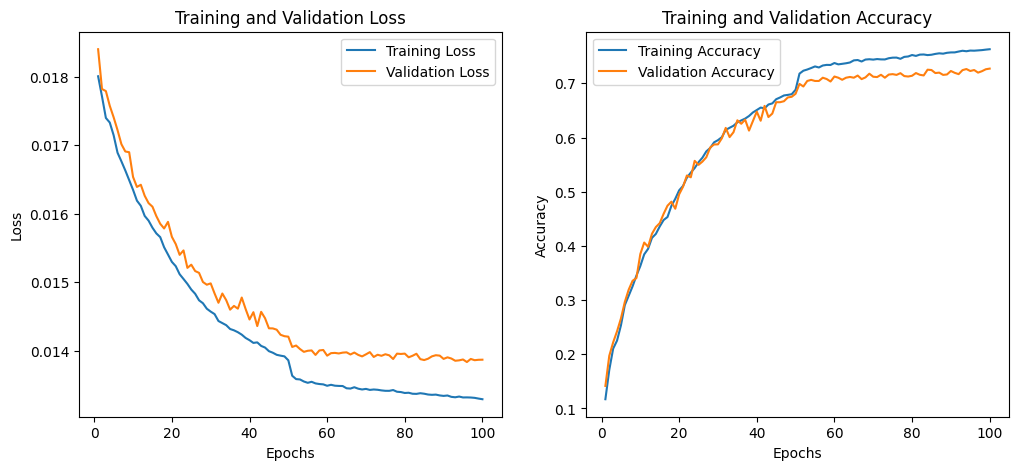

In [14]:
# Plotting
epochs_range = range(1, epochs + 1)

# Plotting Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [15]:
torch.save(model.state_dict(), 'trained_MyResNet_Conv1_1.pth')

# Metrics

In [4]:
!git clone https://github.com/K-Hooshanfar/data_complexity_measures

Cloning into 'data_complexity_measures'...
remote: Enumerating objects: 143, done.
remote: Counting objects: 100% (143/143), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 143 (delta 82), reused 33 (delta 9), pack-reused 0
Receiving objects: 100% (143/143), 144.63 KiB | 20.66 MiB/s, done.
Resolving deltas: 100% (82/82), done.


In [4]:
from data_complexity_measures.models.ARH_SeparationIndex import ARH_SeparationIndex
import torch
from tqdm import tqdm

In [5]:
# Load the pre-trained model
state_dict = torch.load('/content/trained_MyResNet_Conv1_1.pth')

model = MyResNet()
model.load_state_dict(state_dict)

<All keys matched successfully>

In [6]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [7]:
from sklearn.model_selection import train_test_split

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Splitting train dataset into train and validation sets
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Convert test_dataset to a list or NumPy array
test_data_list = [(img, label) for img, label in test_dataset]

# Further split train_dataset into train_loader_dataset and 10% balanced subset
train_loader_dataset, _ = train_test_split(train_dataset.dataset, train_size=int(0.1 * len(train_dataset)),
                                           test_size=None, shuffle=True, stratify=train_dataset.dataset.targets)

# Similarly, for the test_loader
test_loader_dataset, _ = train_test_split(test_data_list, train_size=int(0.1 * len(test_dataset)),
                                          test_size=None, shuffle=True, stratify=test_dataset.targets)

# Data loaders
train_loader = DataLoader(train_loader_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_loader_dataset, batch_size=128, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [8]:
features_per_layer = {}
labels = []

# Get the total number of layers in the model
total_layers = len(list(model.children()))

# Exclude the last four layers
layers_to_be_deleted = set(list(model.children())[-4:])

# Attach hooks to each layer except the excluded ones
features_per_layer = {}
for name, layer in model.named_children():
    if layer not in layers_to_be_deleted:
        features_per_layer[name] = []
        def hook(module, input, output, name=name):
            features_per_layer[name].append(output.detach())
        layer.register_forward_hook(hook)

In [10]:
model.to('cuda:0' if torch.cuda.is_available() else 'cpu')
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    for inputs, targets in tqdm(train_loader):
        inputs = inputs.to(device)
        model(inputs)
        labels.append(targets.cpu())

# Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:
        features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])

labels = torch.cat(labels)

100%|██████████| 36/36 [00:06<00:00,  5.17it/s]


# SI

In [11]:
si_train = []

for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    si = instance_disturbance.si_batch(batch_size=1000)
    si_train.append((layer_name, si))

Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 461.48it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 2896.22it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 2390.73it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 1801.21it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 3835.32it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 2491.57it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 3812.31it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 2038.05it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 4173.44it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 2702.52it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 1607.14it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 4266.84it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 4251.27it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 5098.84it/s]


In [12]:
si_train

[('conv1', 0.2155555635690689),
 ('activation1', 0.21511110663414001),
 ('conv2', 0.21444444358348846),
 ('activation2', 0.2173333317041397),
 ('maxpool1', 0.28155556321144104),
 ('resblock1', 0.36666667461395264),
 ('maxpool2', 0.44644445180892944),
 ('conv3', 0.40933334827423096),
 ('activation3', 0.39266666769981384),
 ('maxpool3', 0.46488890051841736),
 ('conv1x1', 0.09977778047323227),
 ('activation4', 0.14355555176734924),
 ('resblock2', 0.5524444580078125),
 ('avgpool', 0.6193333268165588)]

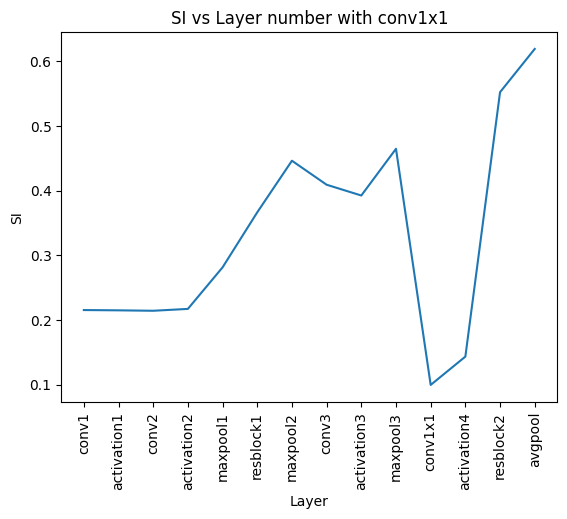

In [17]:
plt.plot([layer for layer, _ in si_train], [si for _, si in si_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('SI vs Layer number with conv1x1')
plt.xticks(rotation=90)
plt.show()

# Center Si

In [14]:
csi_train = []

for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=1000)
    csi_train.append((layer_name, csi))

Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 1939.65it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 1227.12it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 1035.89it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 1794.43it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 1597.34it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 1934.46it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 1606.40it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 1132.37it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 1028.27it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 814.68it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 1858.85it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 1528.31it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 2006.65it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 1601.25it/s]


In [15]:
csi_train

[('conv1', 0.3531111180782318),
 ('activation1', 0.35733333230018616),
 ('conv2', 0.3659999966621399),
 ('activation2', 0.3897777795791626),
 ('maxpool1', 0.44688889384269714),
 ('resblock1', 0.5595555901527405),
 ('maxpool2', 0.5788888931274414),
 ('conv3', 0.5479999780654907),
 ('activation3', 0.5640000104904175),
 ('maxpool3', 0.5879999995231628),
 ('conv1x1', 0.5648888945579529),
 ('activation4', 0.5748888850212097),
 ('resblock2', 0.6671110987663269),
 ('avgpool', 0.6626666784286499)]

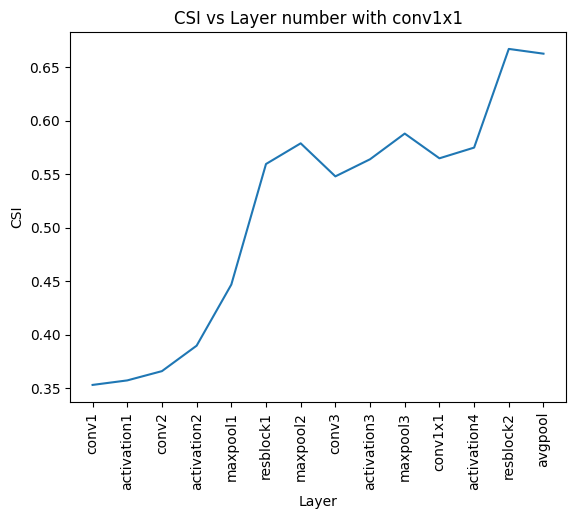

In [18]:
plt.plot([layer for layer, _ in csi_train], [si for _, si in csi_train])
plt.xlabel('Layer')
plt.ylabel('CSI')
plt.title('CSI vs Layer number with conv1x1')
plt.xticks(rotation=90)
plt.show()

# Metrics of Test Loader

In [10]:
model.to('cuda:0' if torch.cuda.is_available() else 'cpu')
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    for inputs, targets in tqdm(test_loader):
        inputs = inputs.to(device)
        model(inputs)
        labels.append(targets.cpu())

# Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:
        features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])

labels = torch.cat(labels)

100%|██████████| 8/8 [00:01<00:00,  5.67it/s]


# SI

In [11]:
si_test = []

for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    si = instance_disturbance.si_batch(batch_size=1000)
    si_test.append((layer_name, si))

Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 524.94it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 2364.32it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 1331.95it/s]

Data has been normalized



Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 1579.18it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 1942.71it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 2748.56it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 441.41it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 2593.88it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 2750.36it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 1125.69it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 995.33it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 2777.68it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 2258.65it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 2949.58it/s]


In [17]:
si_test

[('conv1', 0.1860000044107437),
 ('activation1', 0.18800000846385956),
 ('conv2', 0.18400001525878906),
 ('activation2', 0.19300000369548798),
 ('maxpool1', 0.23500001430511475),
 ('resblock1', 0.32200002670288086),
 ('maxpool2', 0.398000031709671),
 ('conv3', 0.37700000405311584),
 ('activation3', 0.33900001645088196),
 ('maxpool3', 0.4240000247955322),
 ('conv1x1', 0.27800002694129944),
 ('activation4', 0.33900001645088196),
 ('resblock2', 0.4790000319480896),
 ('avgpool', 0.5530000329017639)]

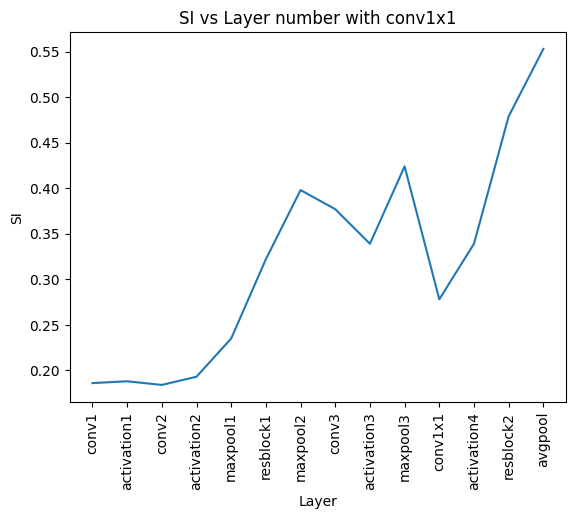

In [12]:
plt.plot([layer for layer, _ in si_test], [si for _, si in si_test])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('SI vs Layer number with conv1x1')
plt.xticks(rotation=90)
plt.show()

# Center Si

In [13]:
csi_test = []

for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=1000)
    csi_test.append((layer_name, csi))

Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 676.83it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1605.78it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1509.29it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1495.30it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 580.45it/s]

Data has been normalized



Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1639.68it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1118.78it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1616.93it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 850.77it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 498.97it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 480.67it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 330.21it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1851.79it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1613.81it/s]


In [14]:
csi_test

[('conv1', 0.42900002002716064),
 ('activation1', 0.4320000112056732),
 ('conv2', 0.45100003480911255),
 ('activation2', 0.4870000183582306),
 ('maxpool1', 0.5250000357627869),
 ('resblock1', 0.6380000114440918),
 ('maxpool2', 0.6240000128746033),
 ('conv3', 0.6030000448226929),
 ('activation3', 0.6390000581741333),
 ('maxpool3', 0.64000004529953),
 ('conv1x1', 0.6220000386238098),
 ('activation4', 0.6390000581741333),
 ('resblock2', 0.6950000524520874),
 ('avgpool', 0.6580000519752502)]

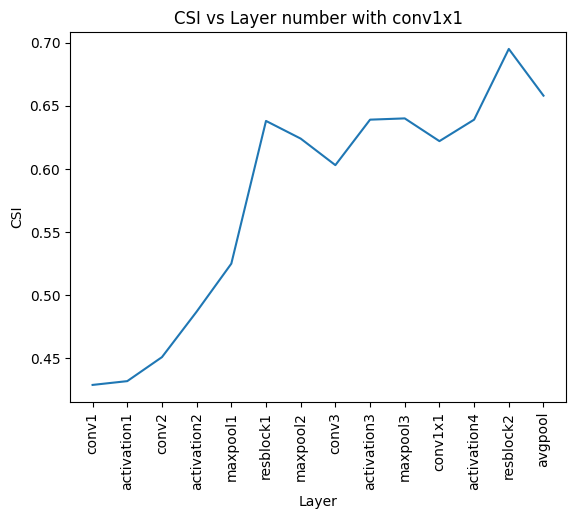

In [16]:
plt.plot([layer for layer, _ in csi_test], [si for _, si in csi_test])
plt.xlabel('Layer')
plt.ylabel('CSI')
plt.title('CSI vs Layer number with conv1x1')
plt.xticks(rotation=90)
plt.show()